In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import (
    ExtraTreesRegressor, 
    RandomForestRegressor, 
    AdaBoostRegressor, 
    HistGradientBoostingRegressor,
    GradientBoostingRegressor )

from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error

In [2]:
trainData = pd.read_csv('../data/train.csv')
testData = pd.read_csv('../data/test.csv')
_1 = pd.read_csv('../data/addData1.csv')
_2 = pd.read_csv('../data/addData2.csv')
_3 = pd.read_csv('../data/addData3.csv')

print('Before:',trainData.shape)
trainData = pd.concat([trainData, _1, _2, _3], axis = 0).drop('id', axis = 1)
print("After:",trainData.shape)

Before: (517754, 14)
After: (629754, 13)


In [3]:
trainData.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [4]:
testData.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


In [5]:
trainData.describe().drop('count')

,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
mean,2.492272,0.490831,46.284597,1.244062,0.357819
std,1.120135,0.275527,15.889807,0.970787,0.169133
min,1.000000,0.000000,25.000000,0.000000,0.000000
25%,1.000000,0.260000,35.000000,1.000000,0.240000
50%,2.000000,0.510000,45.000000,1.000000,0.350000
75%,3.000000,0.720000,60.000000,2.000000,0.470000
max,4.000000,1.000000,70.000000,10.000000,1.000000


In [6]:
testData.describe().drop('count')

,id,num_lanes,curvature,speed_limit,num_reported_accidents
mean,604046.000000,2.494046,0.487263,46.102761,1.186059
std,49821.142441,1.119148,0.272343,15.787077,0.897161
min,517754.000000,1.000000,0.000000,25.000000,0.000000
25%,560900.000000,1.000000,0.260000,35.000000,1.000000
50%,604046.000000,2.000000,0.510000,45.000000,1.000000
75%,647192.000000,3.000000,0.710000,60.000000,2.000000
max,690338.000000,4.000000,1.000000,70.000000,7.000000


In [7]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629754 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               629754 non-null  object 
 1   num_lanes               629754 non-null  int64  
 2   curvature               629754 non-null  float64
 3   speed_limit             629754 non-null  int64  
 4   lighting                629754 non-null  object 
 5   weather                 629754 non-null  object 
 6   road_signs_present      629754 non-null  bool   
 7   public_road             629754 non-null  bool   
 8   time_of_day             629754 non-null  object 
 9   holiday                 629754 non-null  bool   
 10  school_season           629754 non-null  bool   
 11  num_reported_accidents  629754 non-null  int64  
 12  accident_risk           629754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 50.4+ MB


In [8]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      172585 non-null  int64  
 1   road_type               172585 non-null  object 
 2   num_lanes               172585 non-null  int64  
 3   curvature               172585 non-null  float64
 4   speed_limit             172585 non-null  int64  
 5   lighting                172585 non-null  object 
 6   weather                 172585 non-null  object 
 7   road_signs_present      172585 non-null  bool   
 8   public_road             172585 non-null  bool   
 9   time_of_day             172585 non-null  object 
 10  holiday                 172585 non-null  bool   
 11  school_season           172585 non-null  bool   
 12  num_reported_accidents  172585 non-null  int64  
dtypes: bool(4), float64(1), int64(4), object(4)
memory usage: 12.5+ MB


## 1.`Data Visualization`

In [9]:
TARGET = 'accident_risk'
COLUMNS = list(trainData.columns)
COLUMNS.remove(TARGET)

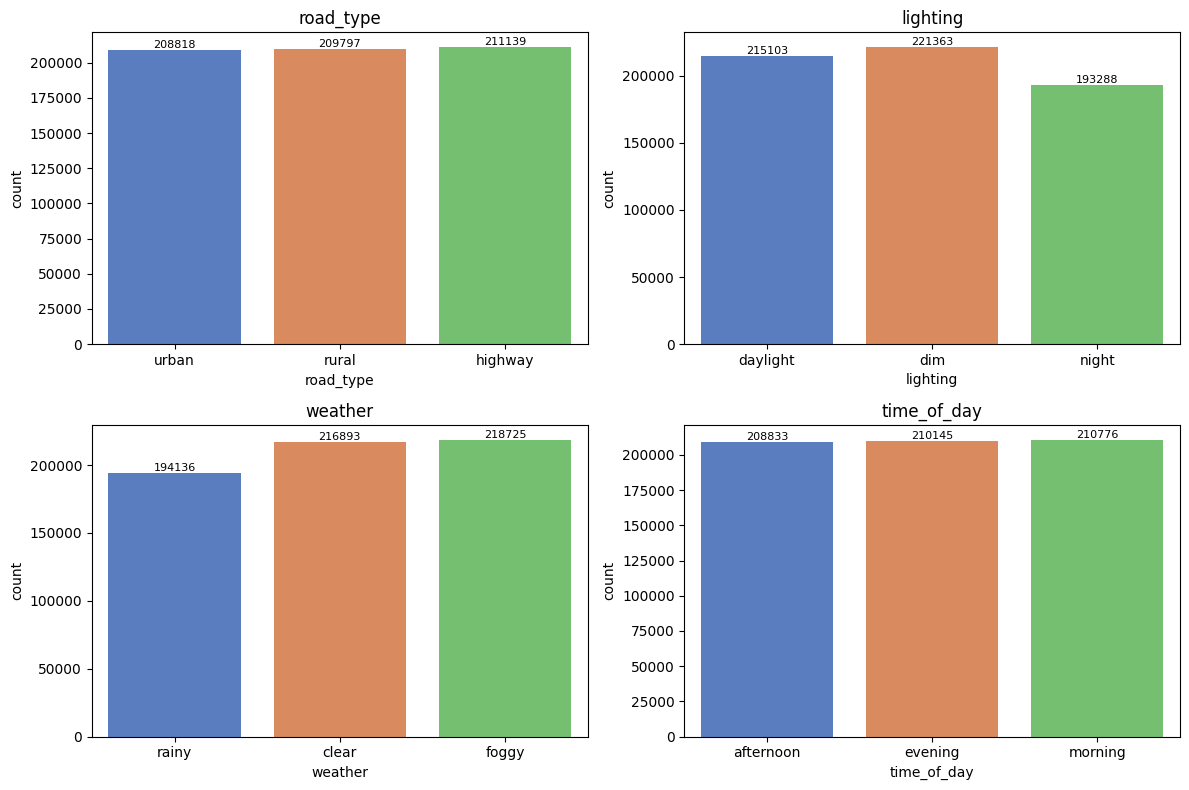

In [10]:
objCols = trainData.select_dtypes('object').columns

fig, axes = plt.subplots(nrows = 2, ncols = len(objCols) // 2, figsize = (12, 8))
axes = axes.flatten()
for col, ax in zip(objCols, axes):
    sns.countplot(data=trainData, x = col, ax = ax, palette='muted')
    ax.set_title(col)
    
    for container in ax.containers:
        ax.bar_label(container, fontsize=8)
    
plt.tight_layout()
plt.show()

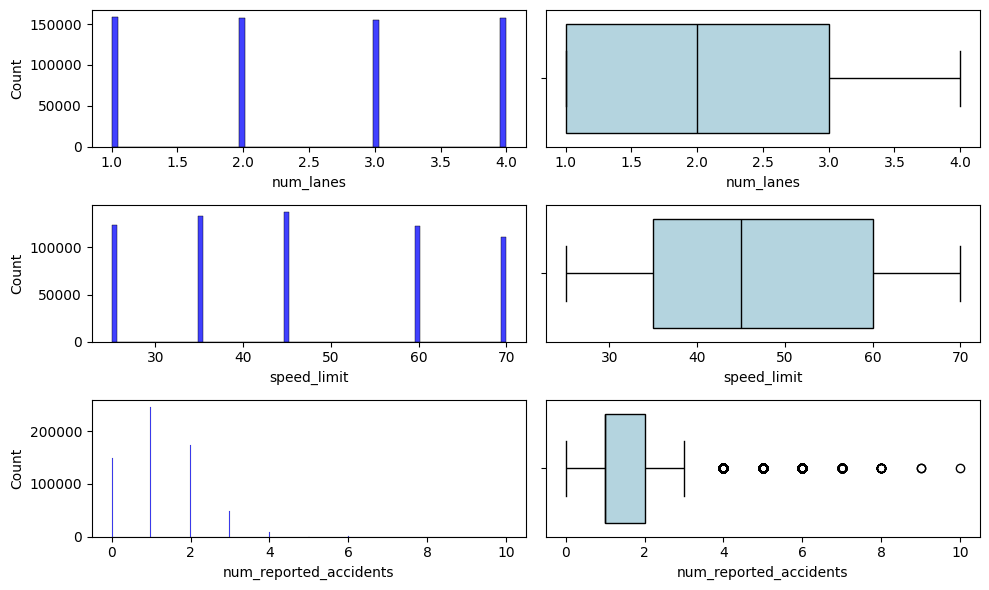

In [11]:
numCols = trainData.select_dtypes('int', 'float').columns

fig, ax = plt.subplots(nrows = len(numCols), ncols = 2, figsize = (10, 2 * len(numCols)))
for index, col in enumerate(numCols):
    sns.histplot(data = trainData, x = col, ax = ax[index, 0], color = 'blue', line_kws={'color' : 'red'})
    sns.boxplot(data=trainData, x=col, ax = ax[index, 1], color = 'lightblue', linecolor='black')

plt.tight_layout()
plt.show()

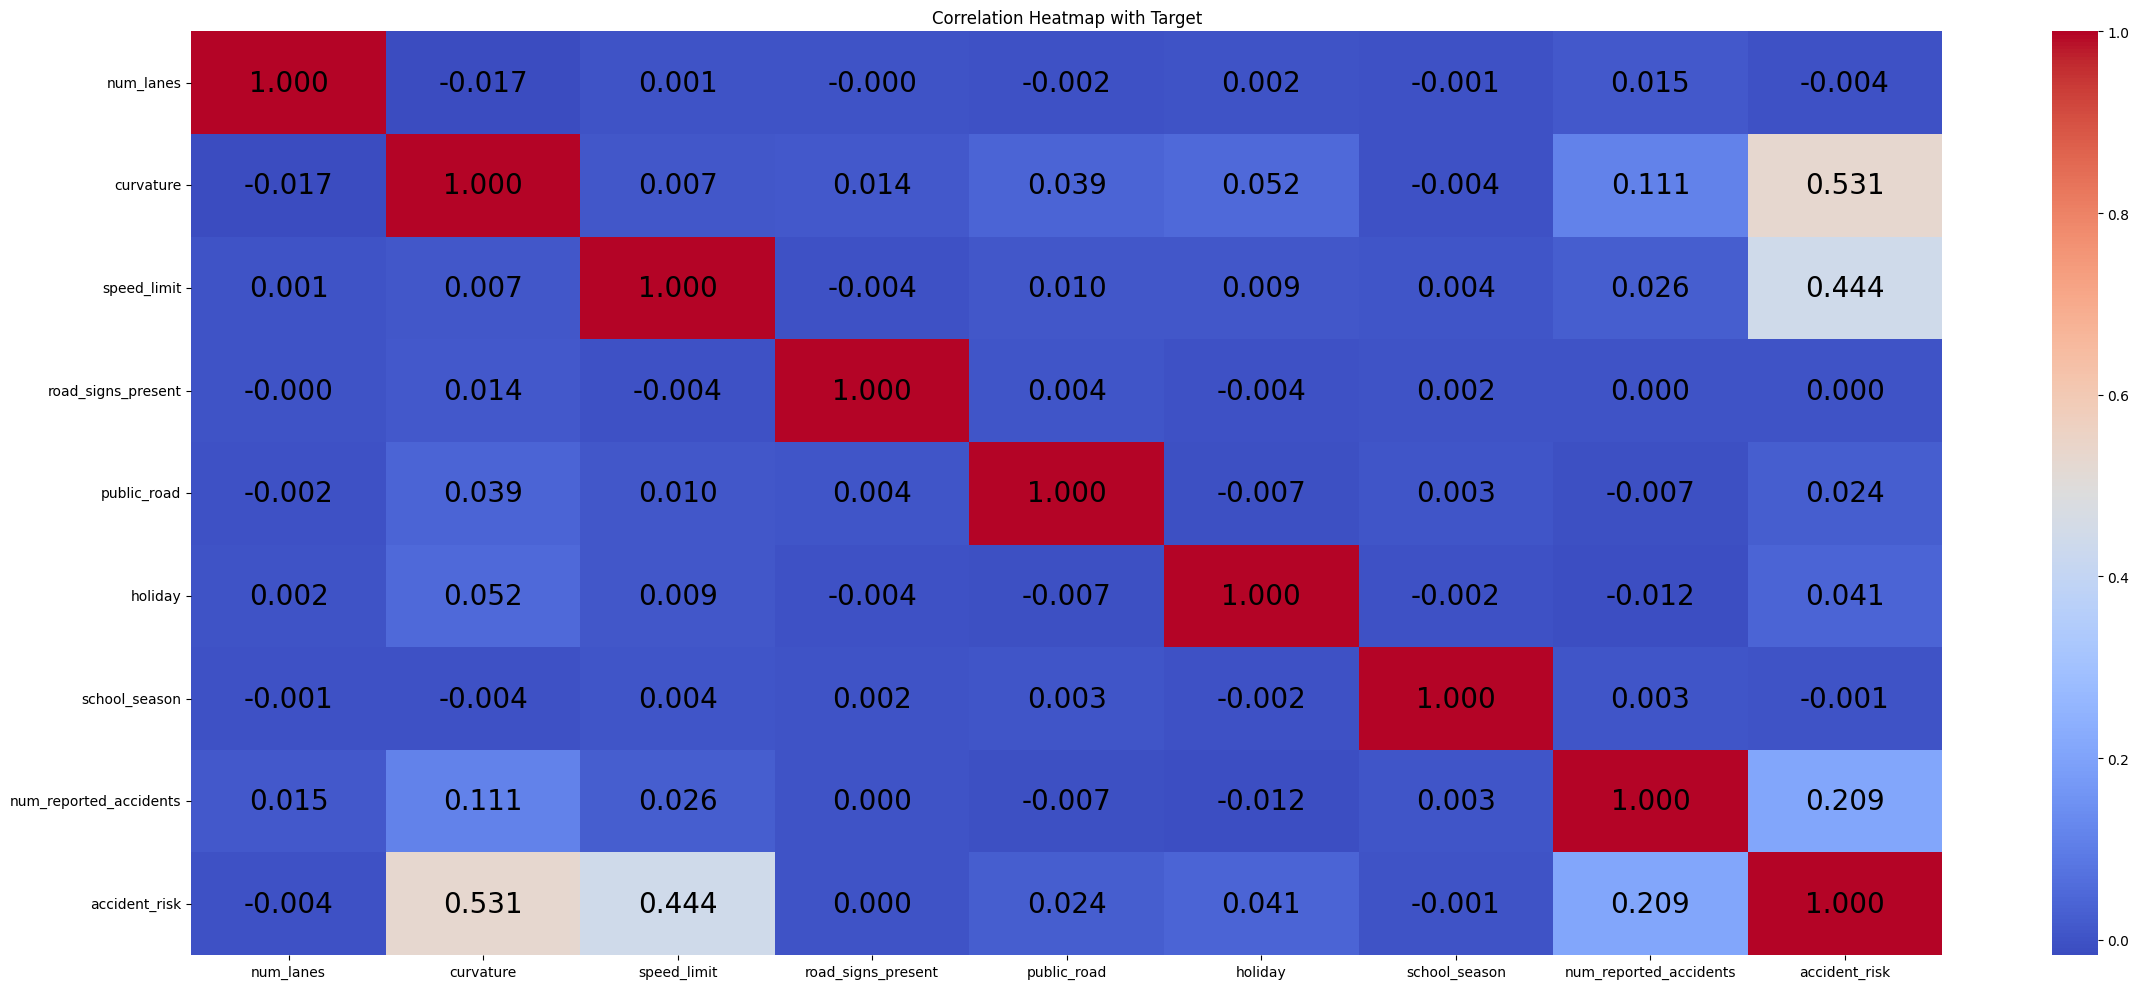

In [12]:
corr = trainData.corr(numeric_only=True)
plt.figure(figsize=(2 * len(COLUMNS), 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".3f", annot_kws={'color' : 'black', 'fontsize' : 20}, linecolor="black")
plt.title("Correlation Heatmap with Target")
plt.tight_layout()
plt.show()

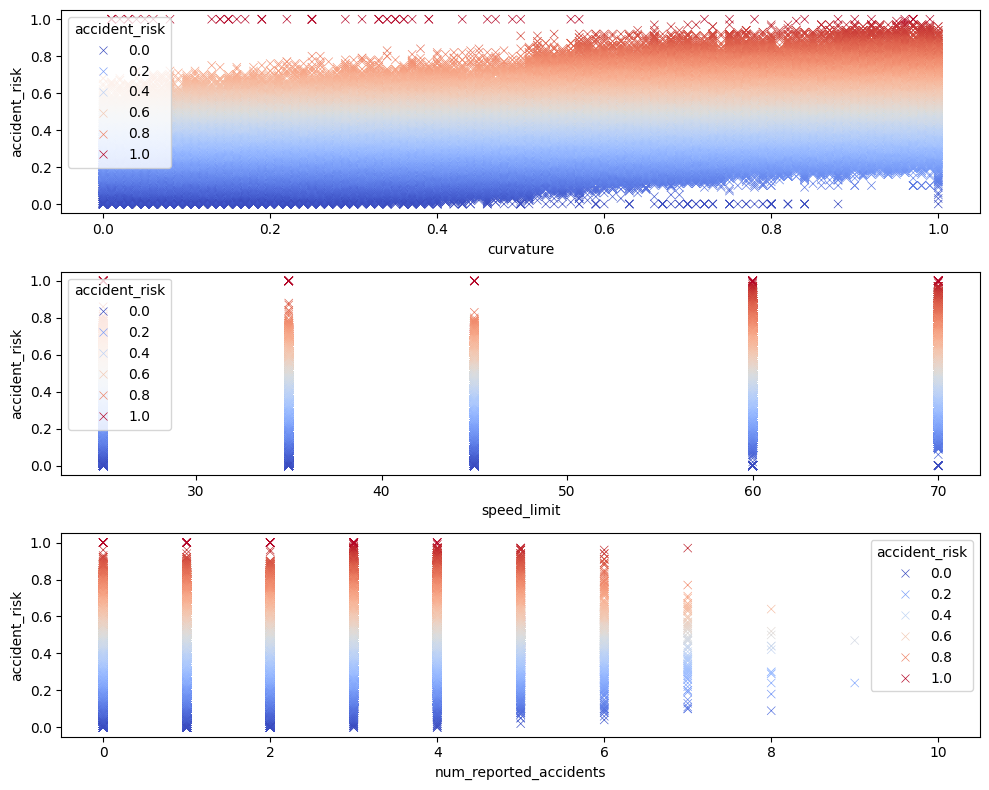

In [13]:
tempCols = ['curvature', 'speed_limit', 'num_reported_accidents']

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 8))
for col, ax in zip(tempCols, axes):
    sns.scatterplot(data = trainData, x = col, y = TARGET, marker = 'x', ax = ax, hue = TARGET, palette='coolwarm')
plt.tight_layout()
plt.show()

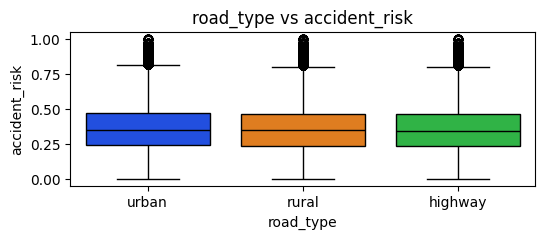

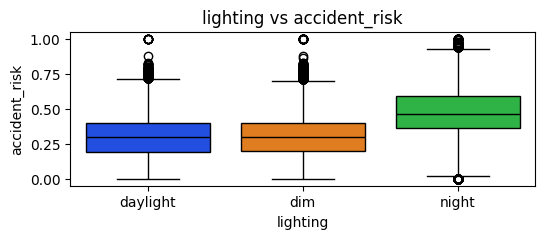

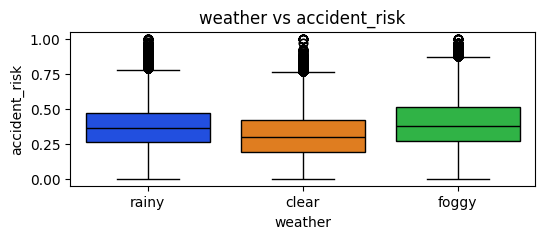

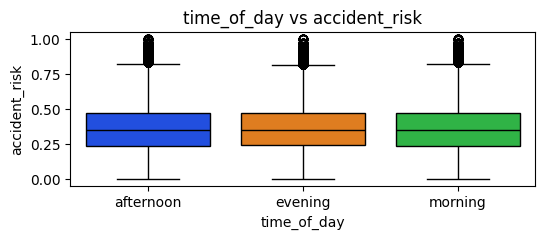

In [14]:
for col in objCols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=trainData[col], y=trainData['accident_risk'], palette='bright', linecolor='black')
    plt.title(f"{col} vs accident_risk")
    plt.show()

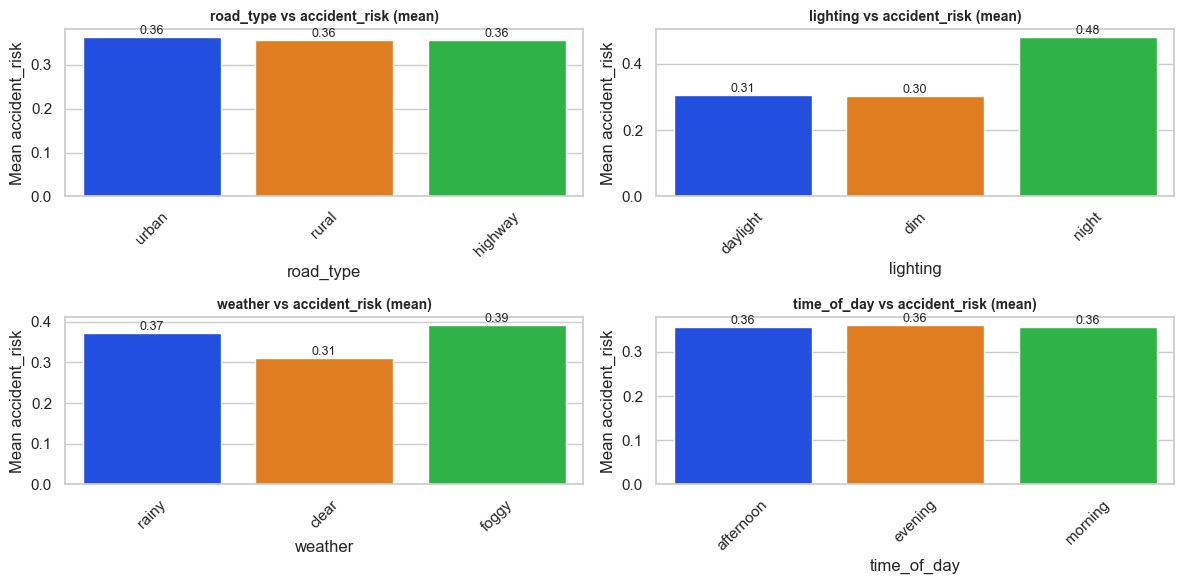

In [15]:
sns.set_theme(style="whitegrid")

# define grid size
n_cols = 2
n_rows = (len(objCols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*3))
axes = axes.flatten()  # flatten in case of single row/column

for i, col in enumerate(objCols):
    ax = axes[i]
    sns.barplot(
        data=trainData,
        x=col,
        y='accident_risk',
        estimator=np.mean,
        ci=None,
        palette='bright',
        ax=ax
    )
    ax.set_title(f"{col} vs accident_risk (mean)", fontsize=10, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylabel("Mean accident_risk")
    
    # Add numbers on top of bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width()/2, height), 
                    ha='center', va='bottom', fontsize=9)

# remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 1.`Data Preprocessing & Visualization`

In [16]:
print('Train nulls:',trainData.isnull().sum().sum())
print('Test nulls:',testData.isnull().sum().sum())

Train nulls: 0
Test nulls: 0


In [17]:
print('Before:',trainData.duplicated().sum())
trainData = trainData.drop_duplicates()
print('After:',trainData.duplicated().sum())

Before: 695
After: 0


In [18]:
COLUMNS = list(trainData.columns)
COLUMNS.remove('accident_risk')

for col in trainData.select_dtypes('object').columns:
    print(f'{col} : {trainData[col].unique()}')

road_type : ['urban' 'rural' 'highway']
lighting : ['daylight' 'dim' 'night']
weather : ['rainy' 'clear' 'foggy']
time_of_day : ['afternoon' 'evening' 'morning']


In [19]:
# converting bool to int (both train and test)
boolCols = trainData.select_dtypes('bool').columns
trainData[boolCols] = trainData[boolCols].astype(int)
testData[boolCols] = testData[boolCols].astype(int)

## 2. `Feature Engineering`

In [20]:
trainData.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.06,35,daylight,rainy,0,1,afternoon,0,1,1,0.13
1,urban,4,0.99,35,daylight,clear,1,0,evening,1,1,0,0.35
2,rural,4,0.63,70,dim,clear,0,1,morning,1,0,2,0.30
3,highway,4,0.07,35,dim,rainy,1,1,morning,0,0,1,0.21
4,rural,1,0.58,60,daylight,foggy,0,0,evening,1,0,1,0.56


['road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents']


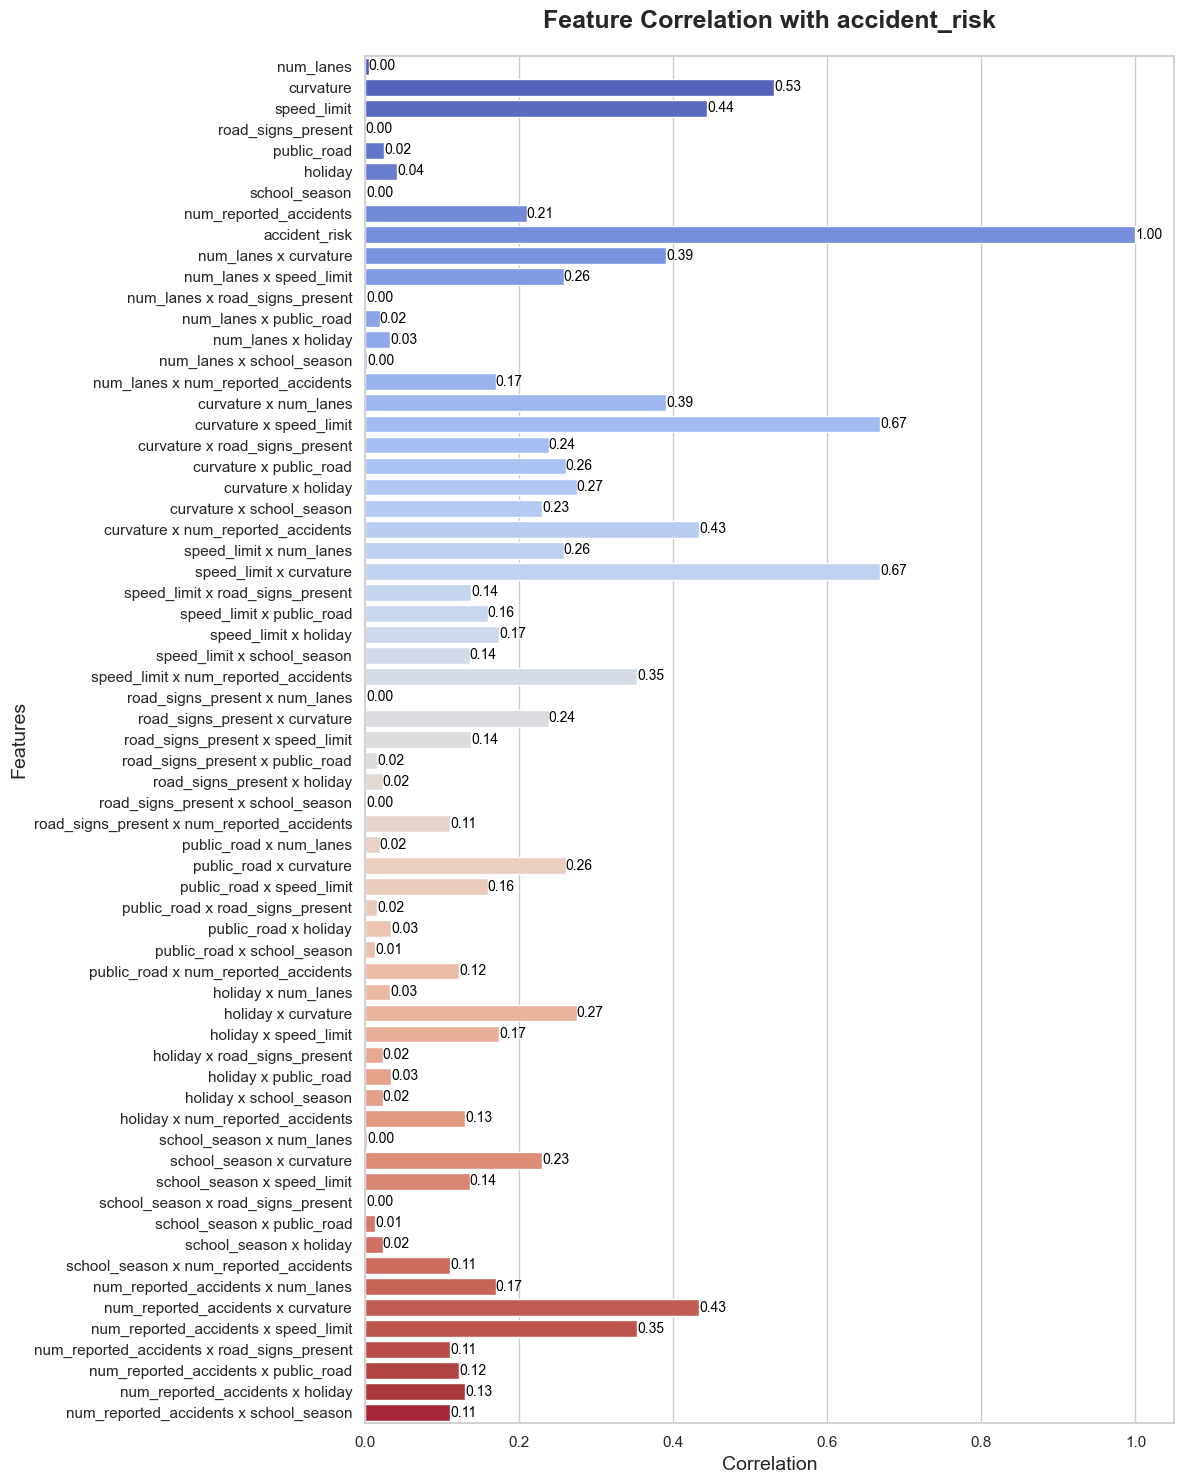

In [21]:
print(COLUMNS)
# interaction features
feTrain = trainData.copy()
feTest = testData.copy()

numCols = list(feTrain.select_dtypes(include=['int64', 'float64']).columns)
numCols.remove('accident_risk')
interFeatures = []

for col1 in numCols:
    for col2 in numCols:
        if col1 != col2:
            interFeatures.append(f'{col1} x {col2}')
            feTrain[f'{col1} x {col2}'] = feTrain[col1] * feTrain[col2]
            feTest[f'{col1} x {col2}'] = feTest[col1] * feTest[col2]

feCorr = abs(feTrain.corr(numeric_only=True, )[TARGET])

plt.figure(figsize=(12, 15))
sns.barplot(y=feCorr.index, x=feCorr.values, palette="coolwarm")  # nice gradient colors
plt.title(f"Feature Correlation with {TARGET}", fontsize=18, weight='bold', pad=20)
plt.xlabel("Correlation", fontsize=14)
plt.ylabel("Features", fontsize=14)

for i, v in enumerate(feCorr.values):
    plt.text(v, i, f"{v:.2f}", ha='left' if v > 0 else 'right', 
             va='center', fontsize=10, color="black")

plt.tight_layout()
plt.show()

In [22]:
highCorrFeatures = feCorr[feCorr > 0.5].index
bestInterFeatures = list(set(highCorrFeatures).intersection(set(interFeatures)))
print('Best Features: ', bestInterFeatures)

allFeatures = COLUMNS + bestInterFeatures
print('\nAll Features:', allFeatures)

feTrain = feTrain[allFeatures + ['accident_risk']]
feTest = feTest[allFeatures + ['id']]

Best Features:  ['speed_limit x curvature', 'curvature x speed_limit']

All Features: ['road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents', 'speed_limit x curvature', 'curvature x speed_limit']


In [23]:
feTrain.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,speed_limit x curvature,curvature x speed_limit,accident_risk
0,urban,2,0.06,35,daylight,rainy,0,1,afternoon,0,1,1,2.10,2.10,0.13
1,urban,4,0.99,35,daylight,clear,1,0,evening,1,1,0,34.65,34.65,0.35
2,rural,4,0.63,70,dim,clear,0,1,morning,1,0,2,44.10,44.10,0.30
3,highway,4,0.07,35,dim,rainy,1,1,morning,0,0,1,2.45,2.45,0.21
4,rural,1,0.58,60,daylight,foggy,0,0,evening,1,0,1,34.80,34.80,0.56


In [24]:
feTest.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,speed_limit x curvature,curvature x speed_limit,id
0,highway,2,0.34,45,night,clear,1,1,afternoon,1,1,1,15.30,15.30,517754
1,urban,3,0.04,45,dim,foggy,1,0,afternoon,1,0,0,1.80,1.80,517755
2,urban,2,0.59,35,dim,clear,1,0,afternoon,1,1,1,20.65,20.65,517756
3,rural,4,0.95,35,daylight,rainy,0,0,afternoon,0,0,2,33.25,33.25,517757
4,highway,2,0.86,35,daylight,clear,1,0,evening,0,1,3,30.10,30.10,517758


In [25]:
# encoding string(object) features
objCols = feTrain.select_dtypes('object').columns

try:
    feTrain = pd.get_dummies(feTrain, columns=objCols, drop_first=True)
    feTest = pd.get_dummies(feTest,  columns=objCols, drop_first=True)
except: 
    pass

# Convert bool → int
boolCols = feTrain.select_dtypes('bool').columns
feTrain[boolCols] = feTrain[boolCols].astype(int)
feTest[boolCols]  = feTest[boolCols].astype(int)

In [26]:
feTrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629059 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   num_lanes                629059 non-null  int64  
 1   curvature                629059 non-null  float64
 2   speed_limit              629059 non-null  int64  
 3   road_signs_present       629059 non-null  int64  
 4   public_road              629059 non-null  int64  
 5   holiday                  629059 non-null  int64  
 6   school_season            629059 non-null  int64  
 7   num_reported_accidents   629059 non-null  int64  
 8   speed_limit x curvature  629059 non-null  float64
 9   curvature x speed_limit  629059 non-null  float64
 10  accident_risk            629059 non-null  float64
 11  road_type_rural          629059 non-null  int64  
 12  road_type_urban          629059 non-null  int64  
 13  lighting_dim             629059 non-null  int64  
 14  lighting_ni

In [27]:
feTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   num_lanes                172585 non-null  int64  
 1   curvature                172585 non-null  float64
 2   speed_limit              172585 non-null  int64  
 3   road_signs_present       172585 non-null  int64  
 4   public_road              172585 non-null  int64  
 5   holiday                  172585 non-null  int64  
 6   school_season            172585 non-null  int64  
 7   num_reported_accidents   172585 non-null  int64  
 8   speed_limit x curvature  172585 non-null  float64
 9   curvature x speed_limit  172585 non-null  float64
 10  id                       172585 non-null  int64  
 11  road_type_rural          172585 non-null  int64  
 12  road_type_urban          172585 non-null  int64  
 13  lighting_dim             172585 non-null  int64  
 14  ligh

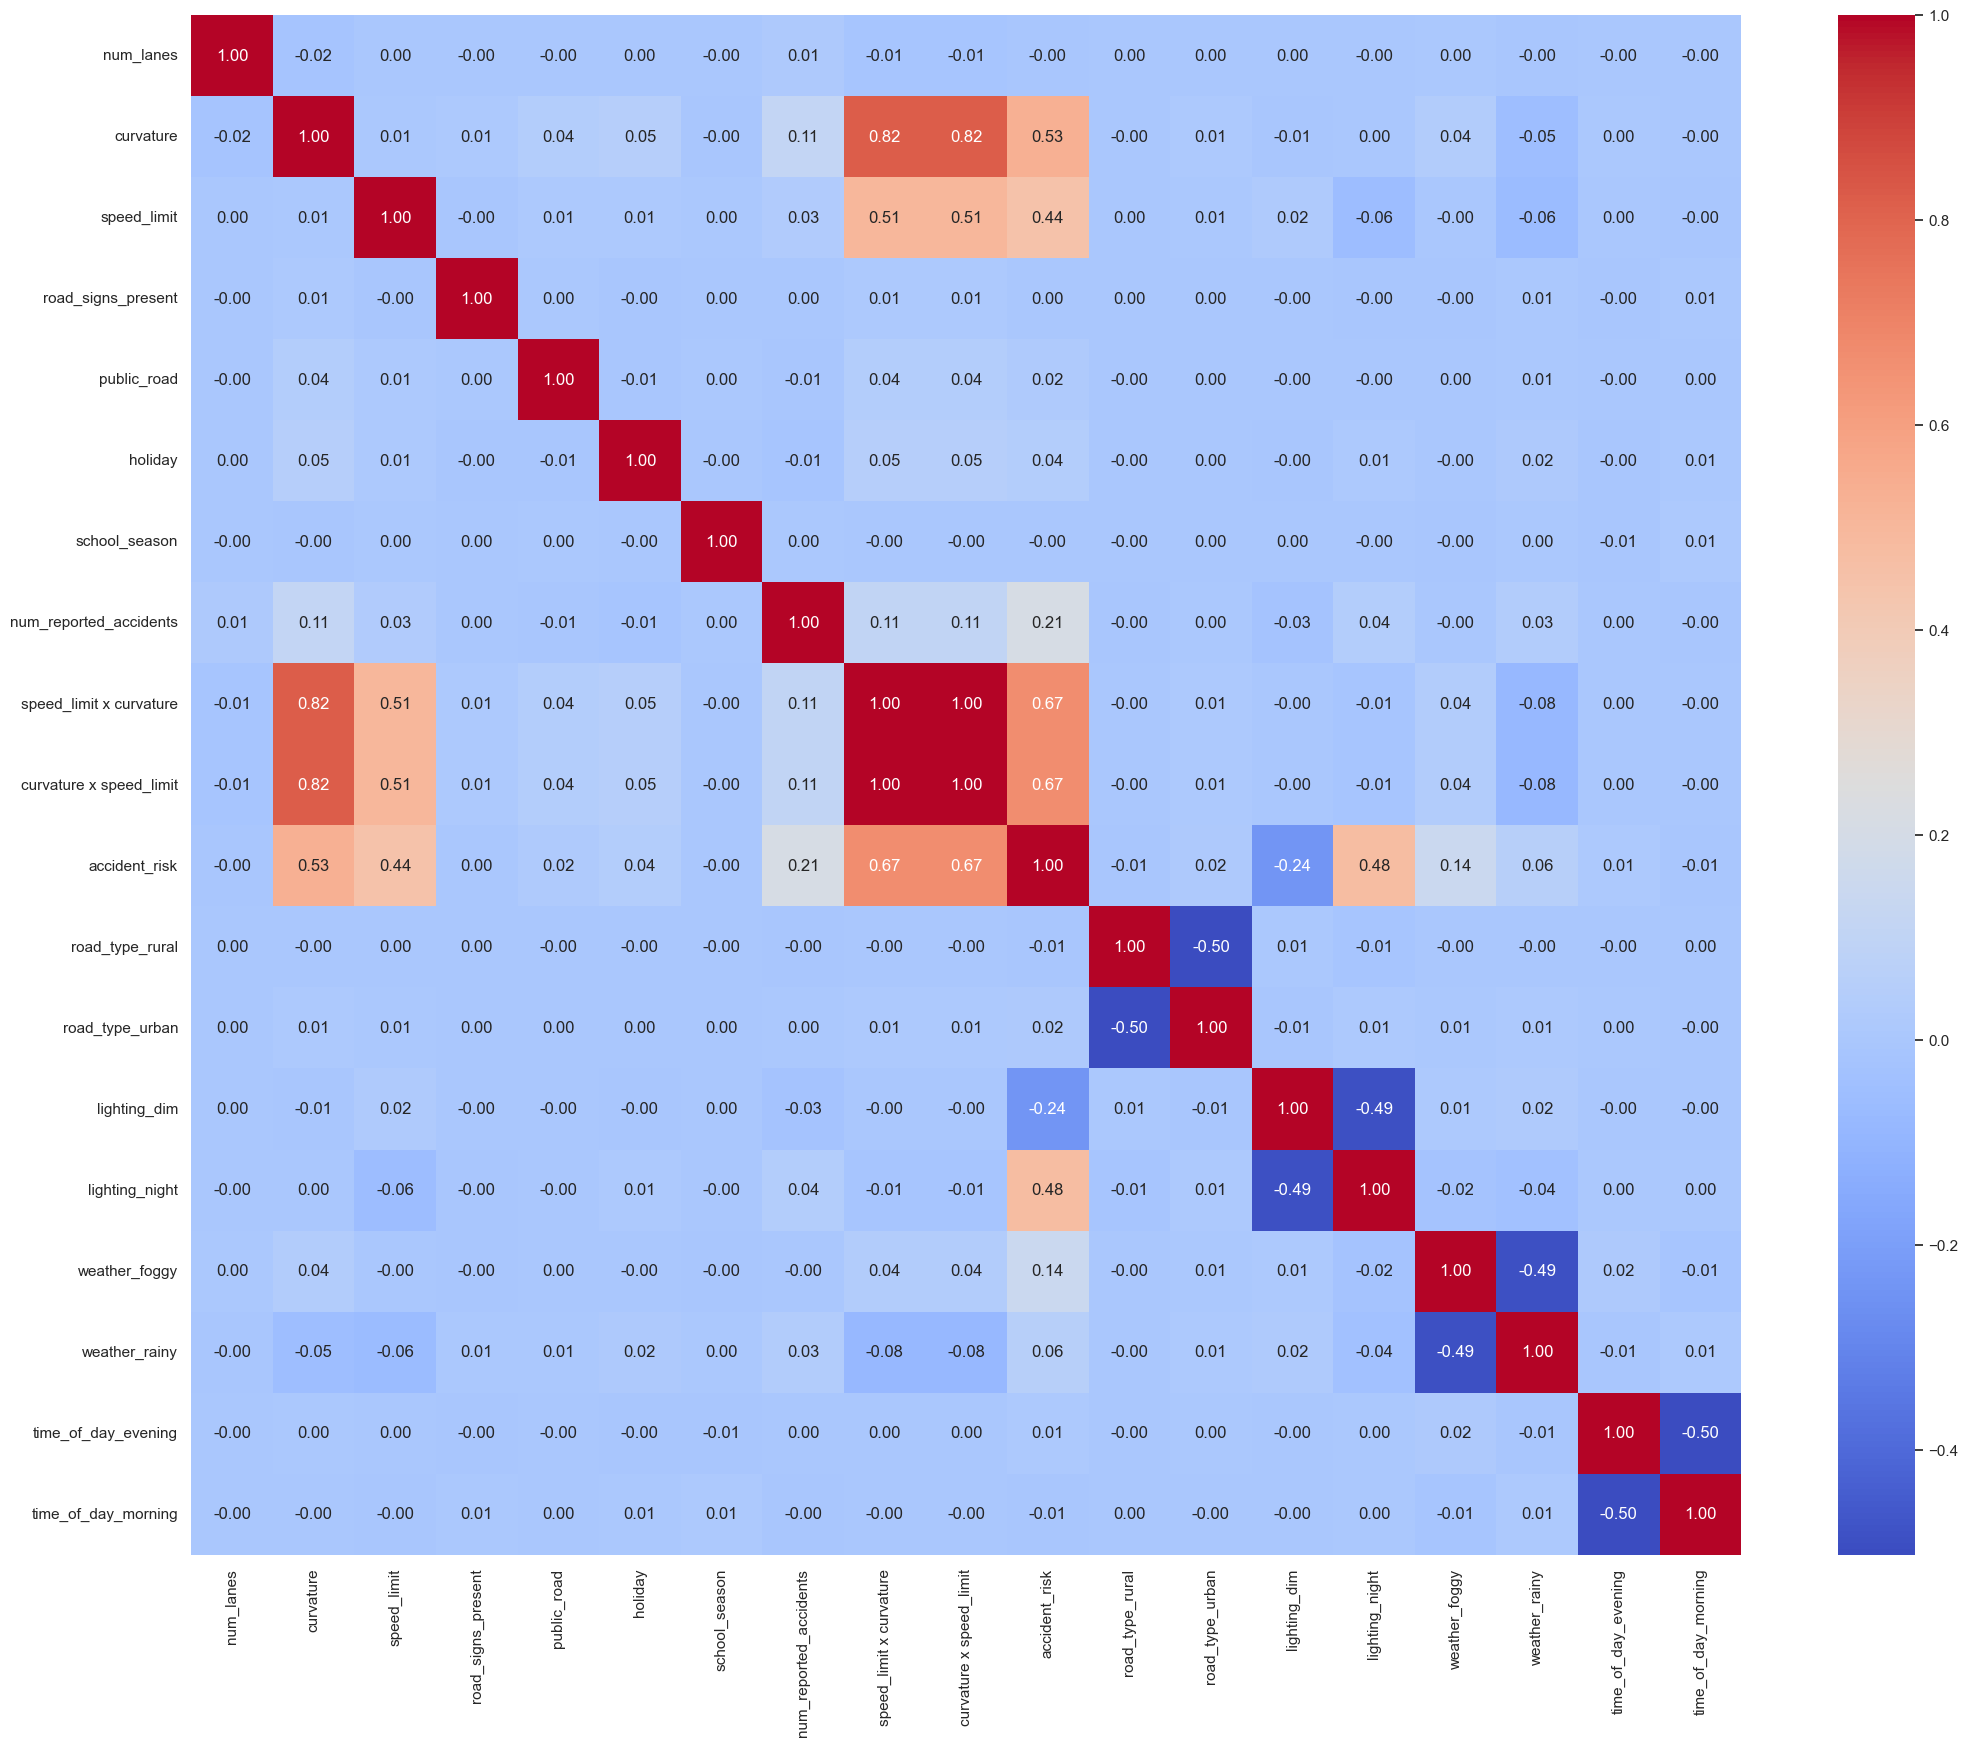

In [28]:
plt.figure(figsize = (25, 20))
sns.heatmap(feTrain.corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.show()

## `Dry Run (Base Model)`

In [29]:
models = {
#     'ExtraTrees' : ExtraTreesRegressor(),
#     'RandomForest' : RandomForestRegressor(),
#     'AdaBoost' : AdaBoostRegressor(),
#     'HistGradient' : HistGradientBoostingRegressor(),
#     'Gradient' : GradientBoostingRegressor()
    'XGB' : XGBRegressor(),
}

def trainModels(models: dict, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    for modelName, model in models.items():
        cv_scores = cross_val_score(
            model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=kf, n_jobs=-1
        )
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        test_rmse = root_mean_squared_error(y_test, pred)

        print(f"{modelName}: CV RMSE = {abs(cv_scores.mean()):.4f}, Test RMSE = {test_rmse:.4f}")
        
def giveSubmission(model, testData : pd.DataFrame, X, y, fileName : str):
    model.fit(X, y)
    drySub = pd.DataFrame({'id' : testData['id'], 'accident_risk' : model.predict(testData.drop('id', axis = 1))})
    if fileName.endswith('.csv'):
        drySub.to_csv(f'../data/submissions/{fileName}', index = False)
    else:
        drySub.to_csv(f'../data/submissions/{fileName}.csv', index = False)

In [30]:
X = feTrain.drop('accident_risk', axis = 1)
y = feTrain['accident_risk']

trainModels(models, X, y)
# giveSubmission(XGBRegressor(), testData, X, y, 'DryRun.csv')

XGB: CV RMSE = 0.0562, Test RMSE = 0.0562


In [31]:
X = feTrain.drop('accident_risk', axis=1)
y = feTrain['accident_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'gpu_hist',
        'device' : 'gpu'
    }

    model = XGBRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    
    return np.mean(scores)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, show_progress_bar=True)

# print("Best RMSE:", np.sqrt(study.best_value))
# print("Best params:", study.best_params)

In [32]:
# best_model = XGBRegressor(**study.best_params)
# best_model.fit(X_train, y_train)
# print(root_mean_squared_error(y_test, best_model.predict(X_test)))
# giveSubmission(best_model, feTest, X, y, 'tunedSub-2.csv')